### **Step-0:** `Setup`

In [6]:
import glob
import numpy as np
import pandas as pd
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

### **Step-1:** `Importing Data` 

Load masing-masing file csv, kemudian gabungkan dan simpan dalam variabel `df`.

In [7]:
# load dataset
path = '../data/raw'
csv_files = glob.glob(path + "/*.csv")
df_list = (pd.read_csv(file) for file in csv_files)

# save into df variable
df = pd.concat(df_list, ignore_index=True)
df.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
181073,ABC3F4E236D2D480,electric_bike,2023-03-03 08:40:01,2023-03-03 08:49:28,Streeter Dr & Grand Ave,13022,Wells St & Hubbard St,TA1307000151,41.892294,-87.612324,41.889906,-87.634266,member
332131,344E8BA12270141A,electric_bike,2023-02-19 16:19:00,2023-02-19 16:22:22,Wells St & Elm St,KA1504000135,Wells St & Huron St,TA1306000012,41.903118,-87.634652,41.894722,-87.634362,member
450403,BD87351B5F298089,electric_bike,2023-01-19 08:43:29,2023-01-19 08:54:20,Financial Pl & Ida B Wells Dr,SL-010,Hermitage Ave & Polk St,13080,41.875085,-87.633136,41.871514,-87.669886,member
438806,E78815724F260014,classic_bike,2023-02-12 17:50:00,2023-02-12 18:47:09,Greenview Ave & Jarvis Ave,520,Sheridan Rd & Argyle St,13059,42.015962,-87.668570,41.973287,-87.654760,casual
451744,20EDB773B8FA4641,classic_bike,2023-01-17 15:33:04,2023-01-17 15:52:05,St. Clair St & Erie St,13016,Canal St & Monroe St,13056,41.894345,-87.622798,41.881690,-87.639530,member


### **Step-2:** `Finding Problematic Data`

Langkah pertama, kita cek apakah ada data dimana pengguna yang sama, pada waktu yang bersamaan, terekam bisa lebih dari satu peminjaman sepeda.

In [8]:
df[df.duplicated(subset=['ride_id', 'started_at', 'ended_at'])]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual


Kemudian, kita lakukan penilaian awal terkait format, tipe, dan unique value pada dataset:

In [9]:
print(f'Jumlah baris dan kolom: {df.shape}')

pd.DataFrame(
    {
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null_value': df.isna().mean().values * 100,
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]
    }
)

Jumlah baris dan kolom: (639424, 13)


,feature,data_type,null_value,n_unique,sample_unique
0,ride_id,object,0.000000,639424,"[6842AA605EE9FBB3, F984267A75B99A8C, FF7CF57CF..."
1,rideable_type,object,0.000000,3,"[electric_bike, classic_bike, docked_bike]"
2,started_at,object,0.000000,594512,"[2023-03-16 08:20:34, 2023-03-04 14:07:06, 202..."
3,ended_at,object,0.000000,595322,"[2023-03-16 08:22:52, 2023-03-04 14:15:31, 202..."
4,start_station_name,object,13.778651,1102,"[Clark St & Armitage Ave, Public Rack - Kedzie..."
5,start_station_id,object,13.799294,1066,"[13146, 491, 620, TA1306000003, 18067, KA15030..."
6,end_station_name,object,14.546842,1120,"[Larrabee St & Webster Ave, nan, Clark St & Ra..."
7,end_station_id,object,14.568893,1082,"[13193, nan, TA1305000030, 13154, TA1306000015..."
8,start_lat,float64,0.000000,196578,"[41.91841316666667, 41.97, 41.898203, 41.88871..."
9,start_lng,float64,0.000000,194605,"[-87.63645116666666, -87.71, -87.637536, -87.6..."


Mari kita lihat pola missing value

<Axes: >

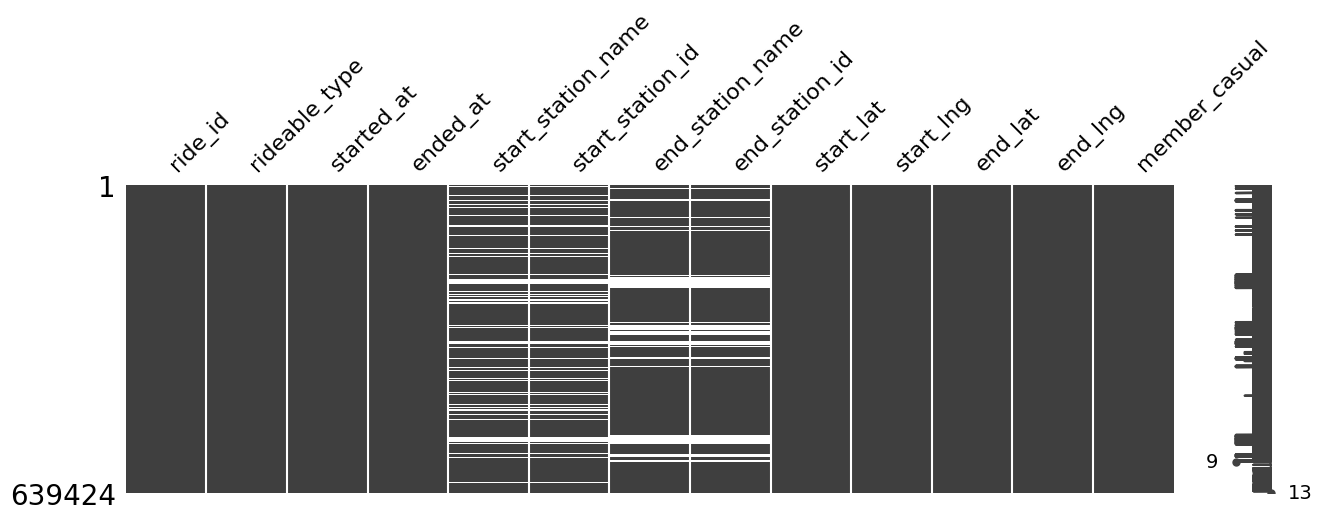

In [10]:
msno.matrix(df, figsize=(15, 4))

Pola missing value antara `start_station_name` dan `start_station_id` keduanya berkorelasi kuat, artinya bisa di pastikan apabila salah satunya missing maka yang lain juga missing. Perilaku yang sama ditunjukkan antara `end_station_name` dan `end_station_id`. Adapun antara kelompok (name & id) `start` atau `end` juga saling berkorelasi, tapi lemah. Artinya bisa saja ketika kelompok `start` missing, belum tentu `end` juga missing, dan sebaliknya.

Kita tangani terlebih dulu missing value pada atribut `end_lat` dan `end_lng`, karena persentase keduanya hanya **0.1%**, maka kita bisa membuangnya menggunakan `dropna()`.

In [11]:
df.dropna(subset=['end_lat', 'end_lng'], axis=0, inplace=True)

Adapun pada kolom `start_station_name`, `start_station_id`, `end_station_name`, dan `end_station_id`, karena jumlahnya cukup besar yaitu **15%**, kita tangani melalui inputasi dengan value sesuai atribut latitude dan longitude yang cocok.

Pisahkan dulu antara dataframe berisi missing value (`with_nans`):

In [12]:
with_nans = df[df.isnull().any(axis=1)]
with_nans.sample(5)
with_nans.shape

(140707, 13)

dan dataframe tanpa missing value (`no_nans`).

In [13]:
no_nans = df[~df.isnull().any(axis=1)]
no_nans.shape

(498291, 13)

Untuk mengisi stasiun yang sesuai, kita perlu buat dataframe berisi daftar nama stasiun berserta titik koordinat nya.

In [14]:
# daftar stasiun awal
cols_start = ["start_station_name", "start_lat", "start_lng", "start_station_id"]
start_station = df.drop_duplicates(subset=cols_start, keep='first')[cols_start]
start_station.rename(columns={'start_station_name': 'name', "start_station_id": 'id', 'start_lat': "lat", 'start_lng': "lng"}, inplace=True)

# daftar stasiun akhir
cols_end = ["end_station_name", "end_lat", "end_lng", "end_station_id"]
end_station = df.drop_duplicates(subset=cols_end, keep='first')[cols_end]
end_station.rename(columns={'end_station_name': 'name', 'end_station_id': 'id', 'end_lat': 'lat', 'end_lng': 'lng'}, inplace=True)

# merge daftar stasiun awal dan akhir
station = pd.concat([start_station, end_station], axis=0)
station.sample(5)

,name,lat,lng,id
523099,Halsted St & Roscoe St,41.943642,-87.648949,TA1309000025
495381,Clinton St & Madison St,41.882523,-87.641407,TA1305000032
472215,Franklin St & Lake St,41.886074,-87.635537,TA1307000111
314626,Sheffield Ave & Wellington Ave,41.936278,-87.652588,TA1307000052
618684,Ritchie Ct & Banks St,41.906716,-87.626132,KA1504000134


Validasi ulang apakah stasiun yang sama mempunyai koordinat yang berbeda.

In [15]:
station = station.groupby(['name', 'lat', 'lng', 'id']).agg(freq=('id', 'count'))
station = station['freq'].groupby(['name'], group_keys=False).apply(lambda x: x.sort_values(ascending=False))
station.to_frame()

freq
name                 lat       lng        id                
2112 W Peterson Ave  41.991178 -87.683593 KA1504000155     2
                     41.991106 -87.683556 KA1504000155     1
                     41.991187 -87.683612 KA1504000155     1
                     41.991194 -87.683601 KA1504000155     1
                     41.991193 -87.683590 KA1504000155     1
...                                                      ...
Yates Blvd & 75th St 41.758694 -87.566571 KA1503000024     1
                     41.758696 -87.566385 KA1503000024     1
                     41.758764 -87.566349 KA1503000024     1
Yates Blvd & 93rd St 41.726166 -87.566276 20237            2
                     41.726147 -87.566348 20237            1

[245030 rows x 1 columns]

Ambil titik koordinat berdasarkan frekuensi terbanyak untuk mewakili masing-masing stasiun

In [16]:
station = station.to_frame().query("freq > 1").reset_index().drop_duplicates(subset='name', keep='first')
station

,name,lat,lng,id,freq
0,2112 W Peterson Ave,41.991178,-87.683593,KA1504000155,2
1,63rd St Beach,41.780911,-87.576324,15491,2
2,900 W Harrison St,41.874754,-87.649807,13028,2
3,Aberdeen St & Jackson Blvd,41.877726,-87.654787,13157,2
5,Aberdeen St & Monroe St,41.880419,-87.655519,13156,2
...,...,...,...,...,...
1260,Woodlawn Ave & 55th St,41.795264,-87.596471,TA1307000164,2
1261,Woodlawn Ave & 75th St,41.759160,-87.595751,569,2
1262,Woodlawn Ave & Lake Park Ave,41.814093,-87.597005,KA1503000065,2
1264,Yates Blvd & 75th St,41.758768,-87.566440,KA1503000024,2


Gunakan dataframe `stasiun` untuk mengisi nan value pada dataframe `with_nans`, di cocok kan dengan titik koordinatnya.

In [17]:
pd.merge(
    left=with_nans,
    right=station.iloc[:, :-1],
    left_on=['start_lat', 'start_lng'],
    right_on=['lat', 'lng'],
    how='left',
)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,name,lat,lng,id
0,F984267A75B99A8C,electric_bike,2023-03-04 14:07:06,2023-03-04 14:15:31,Public Rack - Kedzie Ave & Argyle St,491,NaN,NaN,41.97,-87.71,41.950000,-87.710000,member,Public Rack - Christiana Ave & Lawrence Ave,41.97,-87.71,860
1,F984267A75B99A8C,electric_bike,2023-03-04 14:07:06,2023-03-04 14:15:31,Public Rack - Kedzie Ave & Argyle St,491,NaN,NaN,41.97,-87.71,41.950000,-87.710000,member,Public Rack - Kedzie Ave & Argyle St,41.97,-87.71,491
2,F984267A75B99A8C,electric_bike,2023-03-04 14:07:06,2023-03-04 14:15:31,Public Rack - Kedzie Ave & Argyle St,491,NaN,NaN,41.97,-87.71,41.950000,-87.710000,member,Public Rack - Kimball Ave & Carmen Ave,41.97,-87.71,490
3,F984267A75B99A8C,electric_bike,2023-03-04 14:07:06,2023-03-04 14:15:31,Public Rack - Kedzie Ave & Argyle St,491,NaN,NaN,41.97,-87.71,41.950000,-87.710000,member,Public Rack - Sawyer Ave & Lawrence Ave,41.97,-87.71,861
4,3142E377EBCCB367,electric_bike,2023-03-11 18:30:32,2023-03-11 18:34:49,NaN,NaN,Halsted St & Roscoe St,TA1309000025,41.94,-87.67,41.943670,-87.648950,member,N Paulina St & Lincoln Ave,41.94,-87.67,20253.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160107,9DB29F0B063AC45F,electric_bike,2023-01-19 23:46:47,2023-01-19 23:50:11,NaN,NaN,Ellis Ave & 55th St,KA1504000076,41.79,-87.59,41.794301,-87.601450,member,NaN,NaN,NaN,NaN
160108,6B4E0FE9634C892D,electric_bike,2023-01-15 12:53:12,2023-01-15 12:54:53,NaN,NaN,Columbus Dr & Randolph St,13263,41.89,-87.62,41.884728,-87.619521,member,NaN,NaN,NaN,NaN
160109,A717081A5DF673DD,electric_bike,2023-01-25 18:07:36,2023-01-25 18:11:42,NaN,NaN,Ellis Ave & 55th St,KA1504000076,41.79,-87.60,41.794301,-87.601450,member,NaN,NaN,NaN,NaN
160110,310A65D6CF3A4E32,electric_bike,2023-01-13 17:46:52,2023-01-13 18:05:54,NaN,NaN,Clark St & Chicago Ave,13303,41.92,-87.70,41.896750,-87.630890,member,Milwaukee Ave & Fullerton Ave,41.92,-87.70,428


In [18]:
# isi missing value pada start station
start = pd.merge(
    left=with_nans,
    right=station.iloc[:, :-1],
    left_on=['start_lat', 'start_lng'],
    right_on=['lat', 'lng'],
    how='inner',
)
start.drop(columns=cols_start, inplace=True)
start.columns.values[-4:] = cols_start

# isi missing value pada end station
end = pd.merge(
    left=start,
    right=station.iloc[:, :-1],
    left_on=['end_lat', 'end_lng'],
    right_on=['lat', 'lng'],
    how='inner',
)
end.drop(columns=cols_end, inplace=True)
end.columns.values[-4:] = cols_end

# # merge start dan end
with_nans = pd.concat([start, end])
with_nans

,ride_id,rideable_type,started_at,ended_at,end_station_name,end_station_id,end_lat,end_lng,member_casual,start_station_name,start_lat,start_lng,start_station_id
0,F984267A75B99A8C,electric_bike,2023-03-04 14:07:06,2023-03-04 14:15:31,NaN,NaN,41.950000,-87.710000,member,Public Rack - Christiana Ave & Lawrence Ave,41.97,-87.71,860
1,F984267A75B99A8C,electric_bike,2023-03-04 14:07:06,2023-03-04 14:15:31,NaN,NaN,41.950000,-87.710000,member,Public Rack - Kedzie Ave & Argyle St,41.97,-87.71,491
2,F984267A75B99A8C,electric_bike,2023-03-04 14:07:06,2023-03-04 14:15:31,NaN,NaN,41.950000,-87.710000,member,Public Rack - Kimball Ave & Carmen Ave,41.97,-87.71,490
3,F984267A75B99A8C,electric_bike,2023-03-04 14:07:06,2023-03-04 14:15:31,NaN,NaN,41.950000,-87.710000,member,Public Rack - Sawyer Ave & Lawrence Ave,41.97,-87.71,861
4,860D30DEC2176DDB,electric_bike,2023-03-22 16:51:07,2023-03-22 16:59:00,NaN,NaN,41.970000,-87.720000,member,Public Rack - Christiana Ave & Lawrence Ave,41.97,-87.71,860
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68758,74B3A44866057DB5,electric_bike,2023-02-20 16:47:29,2023-02-20 16:54:39,Elizabeth St & 59th St,647,41.789697,-87.654698,member,Public Rack - Throop St & 58th St,41.79,-87.66,770
68759,E6EA7E792E34BBBE,electric_bike,2023-01-13 06:49:44,2023-01-13 06:58:13,63rd St Beach,15491,41.780911,-87.576324,casual,Public Rack - South Shore Dr & 71st St,41.77,-87.56,948
68760,F0890FF77DAFF01B,electric_bike,2023-02-08 17:04:02,2023-02-08 17:08:03,Public Rack - Stewart Ave & 123rd St,586,41.670000,-87.630000,casual,Public Rack - Stewart Ave & 123rd St,41.67,-87.63,586
68761,25D7A2E941D25ACF,electric_bike,2023-02-08 17:13:28,2023-02-08 18:50:18,Public Rack - Stewart Ave & 123rd St,586,41.670000,-87.630000,casual,Public Rack - Stewart Ave & 123rd St,41.67,-87.63,586


<Axes: >

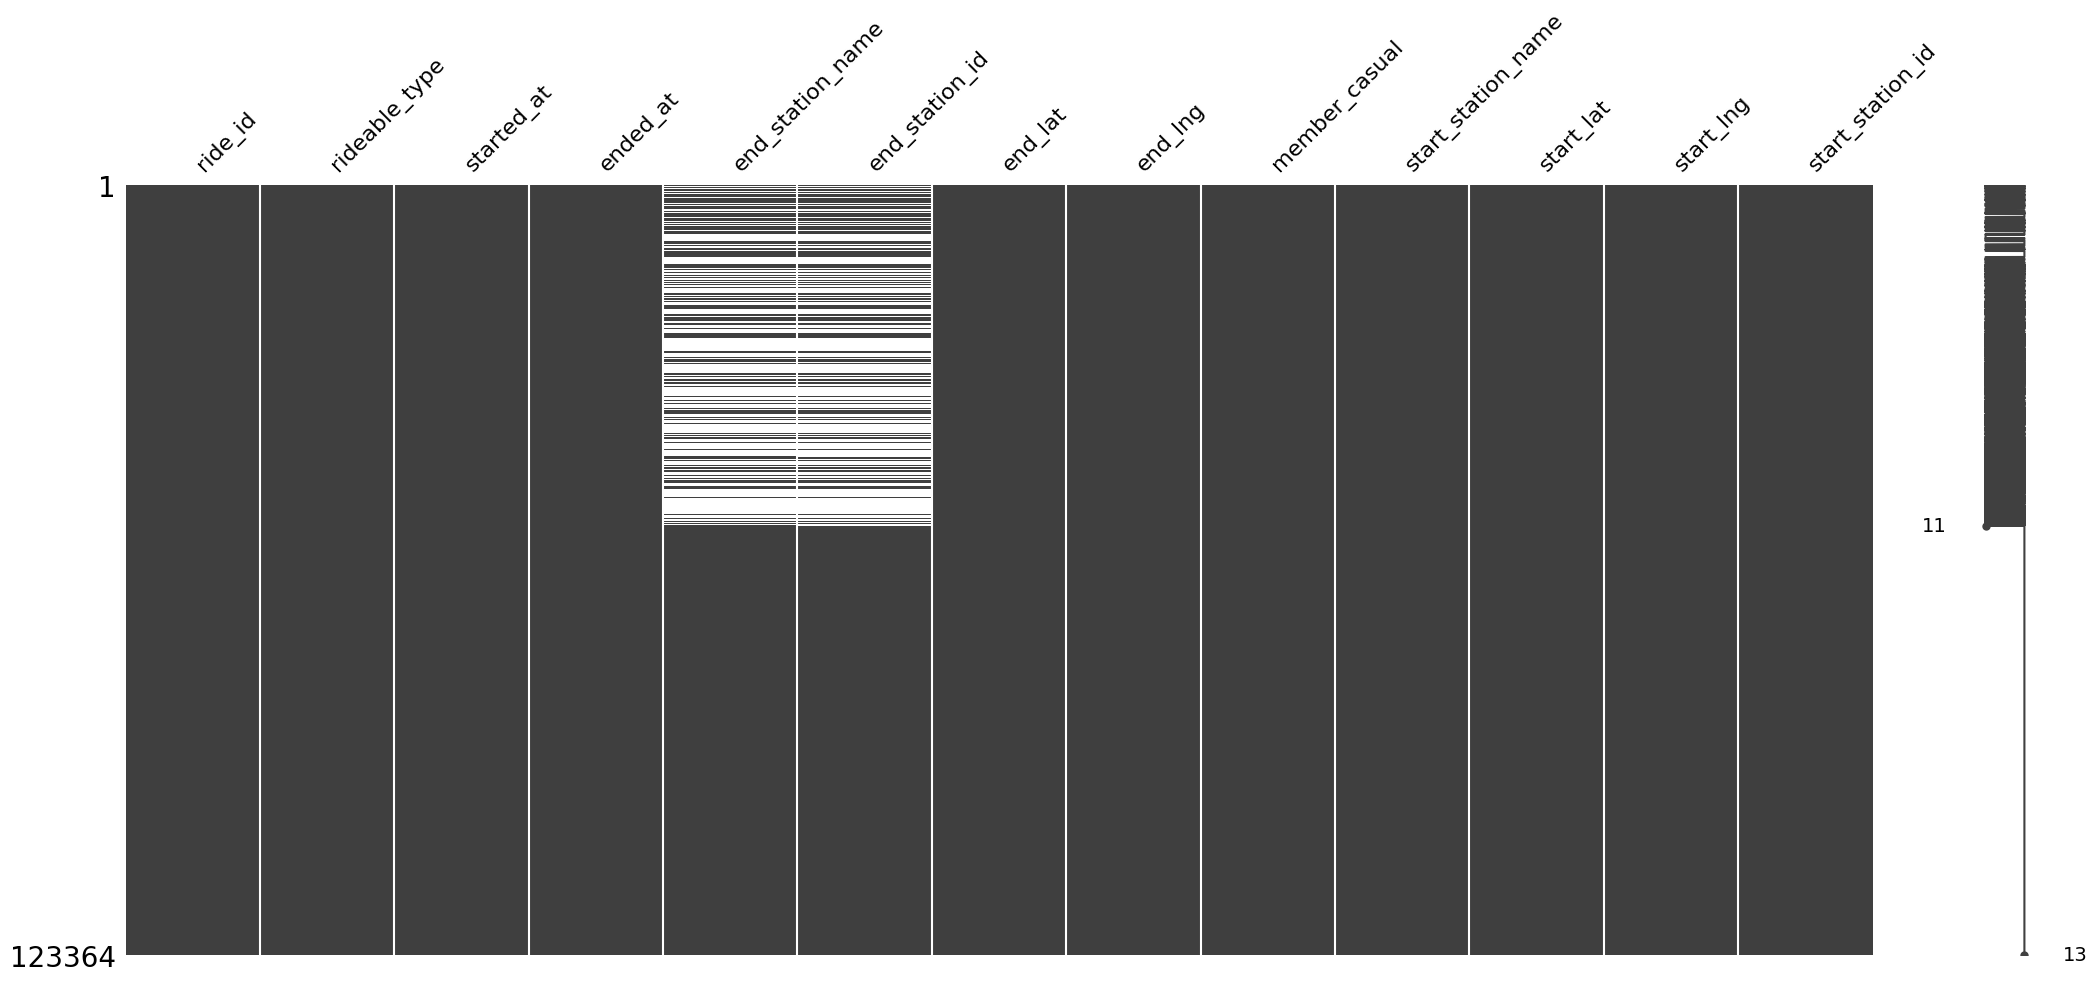

In [19]:
msno.matrix(with_nans)

In [20]:
# drop kolom start station dan end station
# with_nans = b.drop(columns=cols_start + cols_end)

# # rename name_x, name_y, etc
# with_nans.columns.values[-6:] = cols_start + cols_end
# with_nans.sample(5)

In [21]:
b = pd.merge(
    left=with_nans,
    right=station,
    left_on=['start_lat', 'start_lng'],
    right_on=['lat', 'lng'],
    how='inner',
)

In [22]:
80141 + 58435

138576

In [23]:
b.shape

(286592, 18)

Merge dataframa antara `no_nans` dengan `with_nans` setelah dibersihkan 

In [24]:
df_merged = pd.concat([no_nans, with_nans], ignore_index=True, axis=0)
print(f'Jumlah baris dan kolom: {df_merged.shape}')

Jumlah baris dan kolom: (621655, 13)


Terakhir, kita cek duplikat data, jika ada, data tersebut akan diambil salah satunya saja.

In [25]:
df_merged[df_merged.duplicated()]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
552901,C2790FFB1DCF2765,electric_bike,2023-01-07 14:24:40,2023-01-07 14:37:48,N Paulina St & Lincoln Ave,20253.0,Troy St & Grace St,430,41.94,-87.67,41.950000,-87.710000,casual
552902,D218E0119BC9F6DB,electric_bike,2023-03-15 15:43:45,2023-03-15 16:13:25,N Clark St & W Elm St,20249.0,Troy St & Grace St,430,41.90,-87.63,41.950000,-87.710000,member
552903,2BF18B6D352F7B9D,electric_bike,2023-03-01 15:59:43,2023-03-01 16:28:25,N Clark St & W Elm St,20249.0,Troy St & Grace St,430,41.90,-87.63,41.950000,-87.710000,member
552904,A14DC7C848C26ECB,electric_bike,2023-02-27 15:54:55,2023-02-27 16:21:27,N Clark St & W Elm St,20249.0,Troy St & Grace St,430,41.90,-87.63,41.950000,-87.710000,member
552905,2BA5F96B24F4128E,electric_bike,2023-02-13 15:51:53,2023-02-13 16:20:01,N Clark St & W Elm St,20249.0,Troy St & Grace St,430,41.90,-87.63,41.950000,-87.710000,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
621648,B179E65A0AA66459,electric_bike,2023-01-17 11:44:50,2023-01-17 11:54:41,Public Rack - Cottage Grove & 86th St,662,Dauphin Ave & 87th St,20116,41.74,-87.60,41.736559,-87.601258,member
621649,1D248B028D998D18,electric_bike,2023-02-19 08:14:00,2023-02-19 08:18:45,Public Rack - Emerald Ave & 43rd St,911,Halsted St & 47th Pl,KA1503000051,41.82,-87.64,41.808134,-87.645617,member
621650,74B3A44866057DB5,electric_bike,2023-02-20 16:47:29,2023-02-20 16:54:39,Public Rack - Throop St & 58th St,770,Elizabeth St & 59th St,647,41.79,-87.66,41.789697,-87.654698,member
621651,E6EA7E792E34BBBE,electric_bike,2023-01-13 06:49:44,2023-01-13 06:58:13,Public Rack - South Shore Dr & 71st St,948,63rd St Beach,15491,41.77,-87.56,41.780911,-87.576324,casual


### **Step-3:** `Creating New Attributes`

Pertama kita buat atribut lain yang akan dibutuhkan dalam analisis:
* Jarak tempuh (`distance`)
* Durasi pemakaian (`duration`)
* Nama hari saat sewa (`start_day` & `ended_day`)
* Waktu start (`started_at`)
* dan waktu ended (`ended_at`)

In [26]:
df_merged = df_merged.assign(
    distance=haversine(df_merged['start_lat'], df_merged['start_lng'], df_merged['end_lat'], df_merged['end_lng']),
    duration=round(pd.to_timedelta(df_merged['ended_at'] - df_merged['started_at'], unit='seconds').dt.total_seconds() / 60, 2),
    start_day=df_merged['started_at'].dt.day_name(),
    ended_day=df_merged['ended_at'].dt.day_name(),
    start_time=df_merged['started_at'].dt.time,
    ended_time=df_merged['ended_at'].dt.time) \
.query('duration > 0 and distance > 0')

df_merged.sample(5)

NameError: name 'haversine' is not defined

Kemudian kita kelompokan atribut `distance` dan `duration`.

In [ ]:
print(f'Distance: median {df_merged.distance.median()} - MAD {abs(df_merged.distance - df_merged.distance.median()).median()}')
print(f'Duration: median {df_merged.duration.median()} - MAD {abs(df_merged.duration - df_merged.duration.median()).median()}')

Distance: median 1380.0 - MAD 630.0
Duration: median 7.47 - MAD 3.4899999999999998


Gunakan median dan MAD sebagai dasar membagi kelompoknya.

In [ ]:
def convert_duration(x):
    if x > 7.5:
        return '> 7.5 minute'
    elif x <= 12:
        return '0-7.5 minute'
    
def convert_distance(x):
    if 2100 > x > 750:
        return '750-2100 m'
    elif x <= 750:
        return '0-750 m'
    else:
        return '> 2100 m'

df_merged = df_merged.assign(
    class_duration=df_merged.duration.apply(lambda x: convert_duration(x)),
    class_distance=df_merged.distance.apply(lambda x: convert_distance(x)),
)

Dan terakhir kelompokkan `start_day` menjadi `weekend` atau `weekday`

In [ ]:
def convert_day(x):
    if x in ['Friday', 'Saturday', 'Monday']:
        return 'weekend'
    else:
        return 'weekday'
    
df_merged = df_merged.assign(
    weekday=df_merged.start_day.apply(lambda x: convert_day(x))
)

## `Saving Data`

Data mentah yang sudah diolah dan siap di analisis akan kita simpan dalam folder `../data/processed`

In [ ]:
#df_merged.to_csv(f'../data/processed/cleaned_data.csv')